In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, TimeDistributed, Activation, Bidirectional, Lambda, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gdown
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Audio

In [2]:
def download_file_from_google_drive(file_id, dest_path):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', dest_path, quiet=False)

url = 'https://drive.google.com/uc?id=1jyvhdZHn0s5Owkr21k5Ff-c96sIQLtEu'
output = 'all_wav.zip'
download_file_from_google_drive('1jyvhdZHn0s5Owkr21k5Ff-c96sIQLtEu', output)
!unzip -q 'all_wav.zip' -d '/content/all_wav'

url = 'https://drive.google.com/uc?id=1vqvn0F0YYhEFbzLgP9wJ36vyInUnO5b5'
output = 'dataset.csv'
download_file_from_google_drive('1vqvn0F0YYhEFbzLgP9wJ36vyInUnO5b5', output)

Downloading...
From (original): https://drive.google.com/uc?id=1jyvhdZHn0s5Owkr21k5Ff-c96sIQLtEu
From (redirected): https://drive.google.com/uc?id=1jyvhdZHn0s5Owkr21k5Ff-c96sIQLtEu&confirm=t&uuid=11839d2c-ac46-4c3f-a892-2d61f213516c
To: /content/all_wav.zip
100%|██████████| 2.48G/2.48G [00:46<00:00, 53.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vqvn0F0YYhEFbzLgP9wJ36vyInUnO5b5
To: /content/dataset.csv
100%|██████████| 2.87M/2.87M [00:00<00:00, 172MB/s]


In [3]:
wav_files = [f for f in os.listdir('/content/all_wav/all_wav') if f.endswith('.wav')]
print(f"Number of WAV files: {len(wav_files)}")

Number of WAV files: 24366


In [9]:
df = pd.read_csv('/content/dataset.csv')
df.head()

,wav_filename,wav_filesize,transcript,confidence_level
0,./all_wav/Tehran_SayeRoshan0_101.wav,83044,اتفاقاتی که ندیده بودم,0.927557
1,./all_wav/Tehran_SayeRoshan0_105.wav,54468,مسجد,0.927557
2,./all_wav/Tehran_SayeRoshan0_107.wav,136036,جمع شدن مسلمین برای نمازهای جماعت,0.864152
3,./all_wav/Tehran_SayeRoshan0_108.wav,106788,همیشه برای محمدرضا پهلوی,0.927557
4,./all_wav/Tehran_SayeRoshan0_109.wav,170020,چه زمانی در کسوت شاه ایران نوکری اجانب را می‌کرد,0.854824


In [10]:
df['wav_filename'] = df['wav_filename'].apply(lambda x: x.replace('./all_wav/', '/content/all_wav/all_wav/'))

df = df[df['wav_filename'].apply(os.path.isfile)]

In [ ]:
char_map_str = """
' 0
<SPACE> 1
ا 2
ب 3
پ 4
ت 5
ث 6
ج 7
چ 8
ح 9
خ 10
د 11
ذ 12
ر 13
ز 14
ژ 15
س 16
ش 17
ص 18
ض 19
ط 20
ظ 21
ع 22
غ 23
ف 24
ق 25
ک 26
گ 27
ل 28
م 29
ن 30
و 31
ه 32
ی 33
، 34
؟ 35
"""
char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch
index_map[1] = ' '

char_map[' '] = char_map['<SPACE>']

In [ ]:
def load_audio(file_path, sr=16000):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

def extract_features(audio, n_mfcc=20, sr=16000):
    mfcc_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc_features)
    combined = np.vstack((mfcc_features, delta_mfcc)).T
    return combined

def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    augmented_audio = augmented_audio.astype(type(audio[0]))
    return augmented_audio

def shift_time(audio, shift_max=0.2):
    shift = np.random.randint(int(shift_max * 16000))
    if np.random.rand() > 0.5:
        shift = -shift
    augmented_audio = np.roll(audio, shift)
    if shift > 0:
        augmented_audio[:shift] = 0
    else:
        augmented_audio[shift:] = 0
    return augmented_audio

augment_functions = [add_noise, shift_time]
X, y, input_lengths, label_lengths = [], [], [], []

for index, row in df.iterrows():
    audio_path = row['wav_filename']
    audio = load_audio(audio_path)

    features = extract_features(audio)
    X.append(features)
    input_lengths.append(features.shape[0])
    label = [char_map.get(c, char_map[' ']) for c in row['transcript']]
    y.append(label)
    label_lengths.append(len(label))

    for augment_func in augment_functions:
        augmented_audio = augment_func(audio)
        features = extract_features(augmented_audio)
        X.append(features)
        input_lengths.append(features.shape[0])
        y.append(label)
        label_lengths.append(len(label))

if len(X) == 0 or len(y) == 0:
    raise ValueError("No valid audio files were found. Please check the dataset and the paths.")

np.save('/content/X_augmented.npy', X)
np.save('/content/y_augmented.npy', y)
np.save('/content/input_lengths_augmented.npy', input_lengths)
np.save('/content/label_lengths_augmented.npy', label_lengths)

In [ ]:
file_urls = {
    'X_augmented.npy': 'https://drive.google.com/uc?id=1-5QQGFBQuL4AO9XTMwb4o7TlTpsoG9M4',
    'y_augmented.npy': 'https://drive.google.com/uc?id=1-7-Oh7Mj2qaVNr8eBAMhvzMubhDoLsSX',
    'input_lengths_augmented.npy': 'https://drive.google.com/uc?id=1-7yhidCIPb2EdKN7ZDweHOf4Q9sNd63a',
    'label_lengths_augmented.npy': 'https://drive.google.com/uc?id=1-77poJQcMc1V5GqnHLazIfjZcvDbvkVi'
}

for file_name, file_url in file_urls.items():
    gdown.download(file_url, f'/content/{file_name}', quiet=False)

X = np.load('/content/X_augmented.npy', mmap_mode='r')
y = np.load('/content/y_augmented.npy', mmap_mode='r')
input_lengths = np.load('/content/input_lengths_augmented.npy', mmap_mode='r')
label_lengths = np.load('/content/label_lengths_augmented.npy', mmap_mode='r')

Downloading...
From (original): https://drive.google.com/uc?id=1-5QQGFBQuL4AO9XTMwb4o7TlTpsoG9M4
From (redirected): https://drive.google.com/uc?id=1-5QQGFBQuL4AO9XTMwb4o7TlTpsoG9M4&confirm=t&uuid=8a6f97b7-fb31-48a6-b1b4-1d46210054c8
To: /content/X_augmented.npy
100%|██████████| 7.61G/7.61G [00:51<00:00, 147MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-7-Oh7Mj2qaVNr8eBAMhvzMubhDoLsSX
To: /content/y_augmented.npy
100%|██████████| 67.8M/67.8M [00:00<00:00, 202MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-7yhidCIPb2EdKN7ZDweHOf4Q9sNd63a
To: /content/input_lengths_augmented.npy
100%|██████████| 780k/780k [00:00<00:00, 76.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-77poJQcMc1V5GqnHLazIfjZcvDbvkVi
To: /content/label_lengths_augmented.npy
100%|██████████| 780k/780k [00:00<00:00, 110MB/s]


In [ ]:
input_data = Input(name='the_input', shape=(None, 40))
masking_layer = Masking(mask_value=0.0)(input_data)
bilstm_layer_1 = Bidirectional(LSTM(256, return_sequences=True))(masking_layer)
batch_norm_1 = BatchNormalization()(bilstm_layer_1)
dropout_1 = Dropout(0.3)(batch_norm_1)
bilstm_layer_2 = Bidirectional(LSTM(256, return_sequences=True))(dropout_1)
batch_norm_2 = BatchNormalization()(bilstm_layer_2)
dropout_2 = Dropout(0.3)(batch_norm_2)
time_dense = TimeDistributed(Dense(len(char_map) + 1))(dropout_2)
y_pred = Activation('softmax', name='activation')(time_dense)

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

labels = Input(name='the_labels', shape=[None], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss={'ctc': lambda y_true, y_pred: y_pred})

X_train, X_val, y_train, y_val, input_length_train, input_length_val, label_length_train, label_length_val = train_test_split(
    X, y, input_lengths, label_lengths, test_size=0.2, random_state=42)

def data_generator(X, y, input_lengths, label_lengths, batch_size=16):
    while True:
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            input_lengths_batch = input_lengths[i:i+batch_size]
            label_lengths_batch = label_lengths[i:i+batch_size]
            yield (
                {
                    'the_input': np.array(X_batch),
                    'the_labels': np.array(y_batch),
                    'input_length': np.array(input_lengths_batch),
                    'label_length': np.array(label_lengths_batch)
                },
                {'ctc': np.zeros([len(X_batch)])}
            )

train_gen = data_generator(X_train, y_train, input_length_train, label_length_train, batch_size=16)
val_gen = data_generator(X_val, y_val, input_length_val, label_length_val, batch_size=16)

steps_per_epoch = len(X_train) // 16
validation_steps = len(X_val) // 16

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/asr_best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=20, validation_data=val_gen, validation_steps=validation_steps, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
4873/4873 [==============================] - ETA: 0s - loss: 96.1604

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:403: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss={'ctc': lambda y_true, y_pred: y_pred})

  return {key: serialize_keras_object(value) for key, value in obj.items()}


4873/4873 [==============================] - 567s 112ms/step - loss: 96.1604 - val_loss: 77.0823
Epoch 2/20
4873/4873 [==============================] - 544s 112ms/step - loss: 74.2544 - val_loss: 67.3323
Epoch 3/20
4873/4873 [==============================] - 542s 111ms/step - loss: 67.8261 - val_loss: 63.0938
Epoch 4/20
4873/4873 [==============================] - 549s 113ms/step - loss: 64.0866 - val_loss: 60.3931
Epoch 5/20
4873/4873 [==============================] - 544s 112ms/step - loss: 61.4448 - val_loss: 58.4379
Epoch 6/20
4873/4873 [==============================] - 552s 113ms/step - loss: 59.3372 - val_loss: 56.8466
Epoch 7/20
4873/4873 [==============================] - 545s 112ms/step - loss: 57.5770 - val_loss: 55.9241
Epoch 8/20
4873/4873 [==============================] - 537s 110ms/step - loss: 56.1638 - val_loss: 55.1192
Epoch 9/20
4873/4873 [==============================] - 554s 114ms/step - loss: 55.0110 - val_loss: 54.1204
Epoch 10/20
4873/4873 [================

In [ ]:
model.save('/content/asr_model.keras')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 the_input (InputLayer)      [(None, None, 40)]           0         []                            
                                                                                                  
 masking (Masking)           (None, None, 40)             0         ['the_input[0][0]']           
                                                                                                  
 bidirectional (Bidirection  (None, None, 512)            608256    ['masking[0][0]']             
 al)                                                                                              
                                                                                                  
 batch_normalization (Batch  (None, None, 512)            2048      ['bidirectional[0][0]']   

In [ ]:
val_loss = model.evaluate(val_gen, steps=validation_steps)
print(f'Validation Loss: {val_loss}')

In [ ]:
plot_model(model, to_file='/content/model_architecture.png', show_shapes=True, show_layer_names=True)

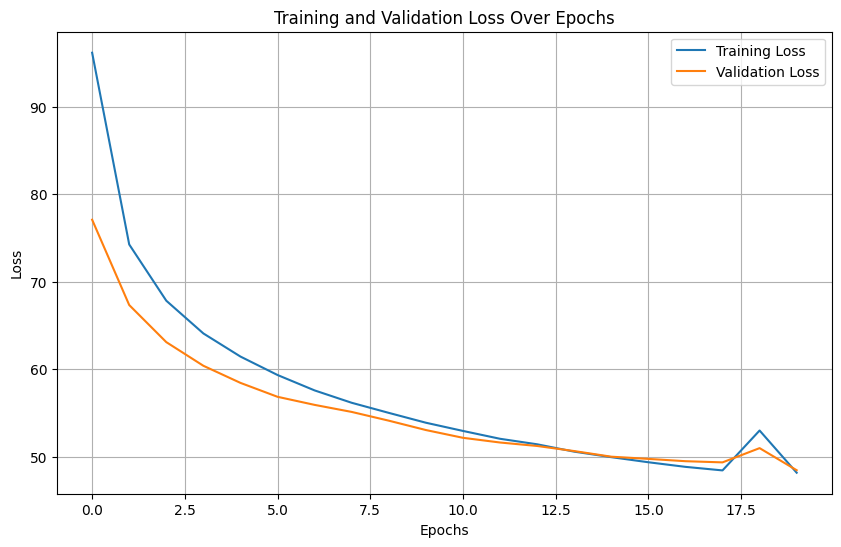

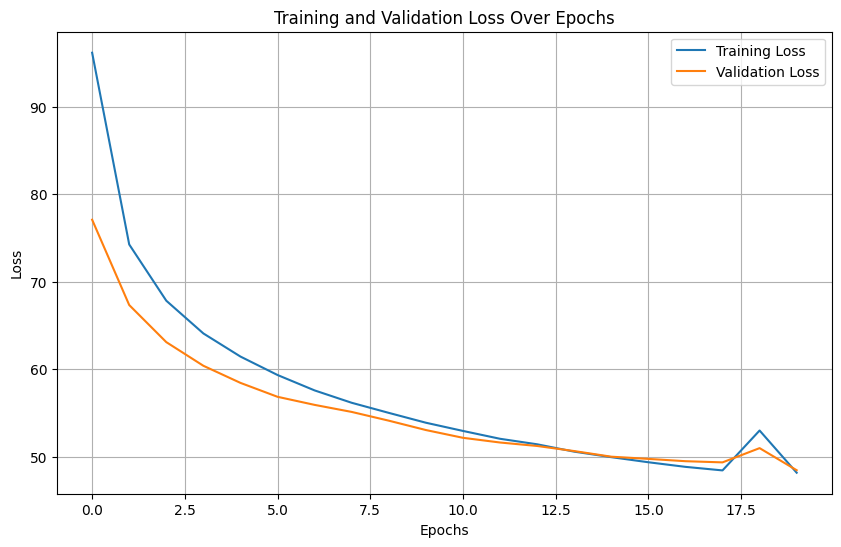

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)

In [ ]:
inference_model = Model(inputs=input_data, outputs=y_pred)

inference_model.load_weights('/content/asr_best_model.keras')

def predict_sample(sample_index):
    sample_features = X[sample_index]
    sample_input_length = np.array([sample_features.shape[0]])

    sample_features = np.expand_dims(sample_features, axis=0)
    sample_input_length = np.array([sample_features.shape[1]], dtype=np.int32)

    # Predict with beam search decoding
    preds = inference_model.predict(sample_features)
    decoded_pred = tf.keras.backend.ctc_decode(preds, input_length=sample_input_length, greedy=False, beam_width=20, top_paths=1)[0][0]
    decoded_pred = tf.keras.backend.get_value(decoded_pred)

    # Ensure decoded_pred is a 1D array
    decoded_pred = decoded_pred.flatten()

    # Convert the decoded prediction to text
    predicted_text = ''.join([index_map[i] for i in decoded_pred if i != -1])

    actual_text = df.iloc[sample_index]['transcript']

    print(f"Predicted text: {predicted_text}")
    print(f"Actual text: {actual_text}")

# Test the model on a new sample
predict_sample(25)

1/1 [==============================] - 0s 25ms/step
Predicted text: دس بردار ازیم کارا
Actual text: دست بردار از این کارها


In [6]:
def load_audio(file_path, sr=16000):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

In [11]:
def get_filename_for_sample(sample_index):
    return df.iloc[sample_index]['wav_filename']
get_filename_for_sample(25)

'/content/all_wav/all_wav/Tehran_SayeRoshan0_150.wav'

In [4]:
def play_wav(file_path):
    audio = load_audio(file_path)
    return Audio(audio, rate=16000)

In [12]:
play_wav('/content/all_wav/all_wav/Tehran_SayeRoshan0_150.wav')